### **Introduction**
This project is my first step into the world of data analysis and understanding what it takes to work with data.

The idea behind this project is simple, pick a dataset, learn to clean, analyze and extract statistical insights, then create visualizations that communicate some of the findings.

LINK TO DATASET: https://www.kaggle.com/datasets/harshitshankhdhar/imdb-dataset-of-top-1000-movies-and-tv-shows

For this mini project, I decided to use a dataset containing the top 1000 IMDB movies from Kaggle.

### **Part 1: Data Exploration and Cleaning**

In [132]:
# importing Python libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### **Data Overview**
- how many rows and columns does the dataset have?
- what are the data types of each column? are there any missing values?

In [133]:
# reading data from .csv file
data = pd.read_csv("imdb_top_1000.csv")

In [134]:
data.shape

(1000, 16)

There are 1000 rows and 16 columns, in the dataset. This is prior to cleaning the dataset of unnecessary columns.

In [135]:
data.dtypes

Poster_Link       object
Series_Title      object
Released_Year     object
Certificate       object
Runtime           object
Genre             object
IMDB_Rating      float64
Overview          object
Meta_score       float64
Director          object
Star1             object
Star2             object
Star3             object
Star4             object
No_of_Votes        int64
Gross             object
dtype: object

Majority of the data types in the dataset are objects (which can contain both characters and numbers). Columns such as `Released_Year`, `Runtime`, `Gross` should be converted to `int64` to make it easier to work with. Additionally, columns such as `Poster_Link`, `Certificate`, `Overview` and `Meta_score` are unnecessary for my use case and could be removed. 

In [136]:
data.isna().sum()

Poster_Link        0
Series_Title       0
Released_Year      0
Certificate      101
Runtime            0
Genre              0
IMDB_Rating        0
Overview           0
Meta_score       157
Director           0
Star1              0
Star2              0
Star3              0
Star4              0
No_of_Votes        0
Gross            169
dtype: int64

The table above shows the number of null values for each column. I will have to find a way to handle null values for `Gross`

In [137]:
data.duplicated().sum()

0

There are no duplicate rows in the dataset.

#### **Data Cleaning**
- identify and handle any missing or inconsistent data
- are there any outliers in the dataset? if so, how would you handle them?

In [138]:
# dropping unnecessary columns
data = data.drop(columns=["Poster_Link", "Certificate", "Overview", "Meta_score", "No_of_Votes"])

# dropping rows where Gross is NaN because no other method makes sense
data = data.dropna(subset="Gross")

# renaming columns 
data = data.rename(columns={"Series_Title" : "Movie_Title", "Released_Year" : "Release_Year"})

# using the Movie_Title as the index instead of 0,1,2...
data = data.set_index("Movie_Title")

In [139]:
data.isna().sum()

Release_Year    0
Runtime         0
Genre           0
IMDB_Rating     0
Director        0
Star1           0
Star2           0
Star3           0
Star4           0
Gross           0
dtype: int64

After removing any columns that were not needed, renaming some to eliminate confusion and changing the index, did a recheck for any null values that may have been missed and its looking good. Doing a premature check (`data.max()`) to see if the data types should be changed, it is obvious that a max Runtime of 99 min and the highest Gross revenue of $985, 912 make no sense at all and can be confirmed by just reading the first few rows of `data.head(5)`. This confirms that some of the data types should be converted to make sure they make sense.

In [140]:
# remove any non-numeric characters (e.g., strip whitespaces) and convert to int
data['Release_Year'] = pd.to_numeric(data['Release_Year'], errors='coerce').astype('Int64')

# extract numeric values from Runtime and convert to int
data['Runtime'] = data['Runtime'].str.extract(r'(\d+)').astype('Int64')

# remove non-numeric characters (like $, commas) and convert to int
data['Gross'] = data['Gross'].replace(r'[\$,]', '', regex=True).astype('Int64')

After performing the conversions and doing a recheck (`data.max()`), the outputs make much more sense. And can further be verified by doing `data.sort_values(by=["Gross"], ascending=False)`. Replace "Gross" with another column name and match with the output of `data.max()` to make sure the values are correct.

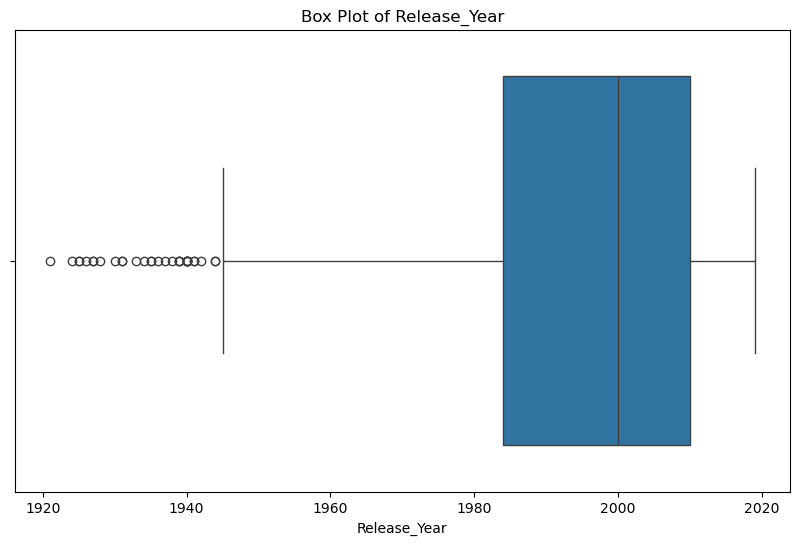

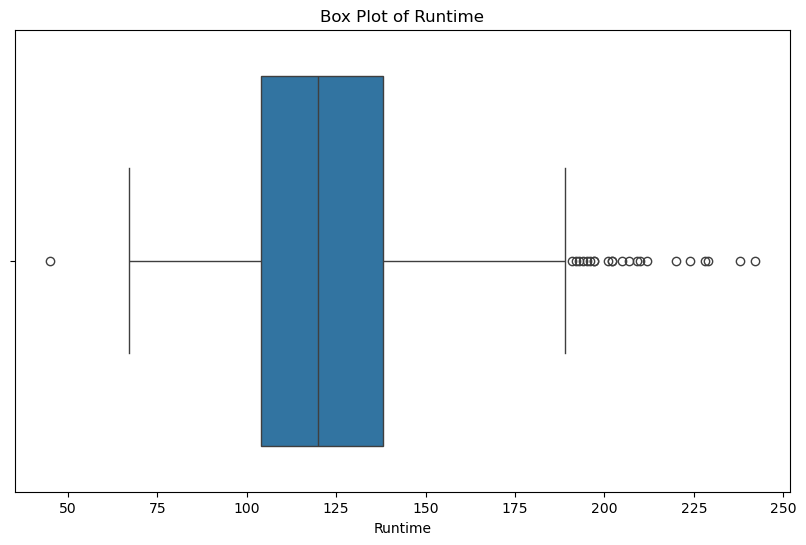

In [141]:
numeric_columns = ["Release_Year", "Runtime"]

for column in numeric_columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=data[column])
    plt.title(f"Box Plot of {column}")
    plt.show()

There are several movies in the dataset that were released prior to 1940 which make them not as useful for this analysis and are considered outliers, and will be removed. Additionally, there are several movies that go beyond the 3hr mark and closer to 4hrs. For this analysis, only movies released on or after 1970 (approx. the past 50 years) and a runtime between 1hr and 3.5hr will be considered.

In [142]:
# filtering all movies that were released prior to 1970
data = data[data["Release_Year"] >= 1970]

# filtering all movies that are shorter than 1hr and longer than 3.5hrs
data = data[(data["Runtime"] >= 60) & 
            (data["Runtime"] <= 210)]

After filtering the rows that are not needed and creating another boxplot, many of the outliers have been removed. The reason for not removing all the outliers with respect to runtime is because they contribute 10's to 100's of millions in gross revenue to the movie. Eliminating them would skew the results greatly.

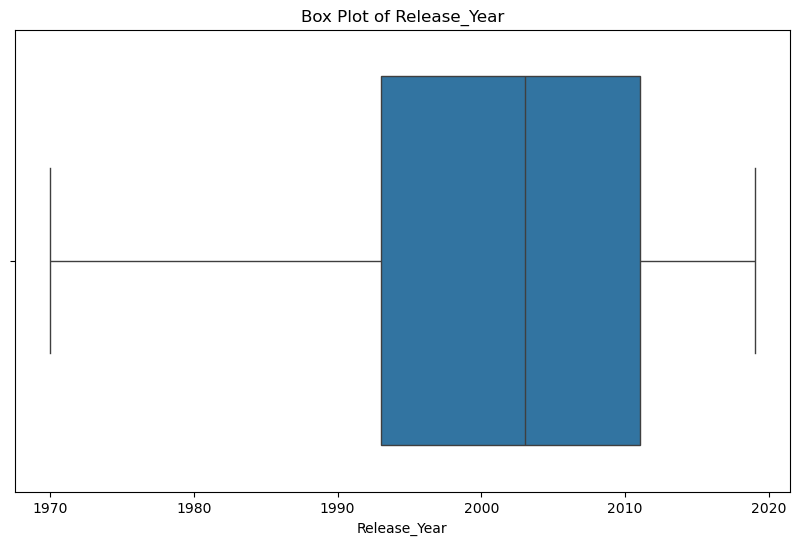

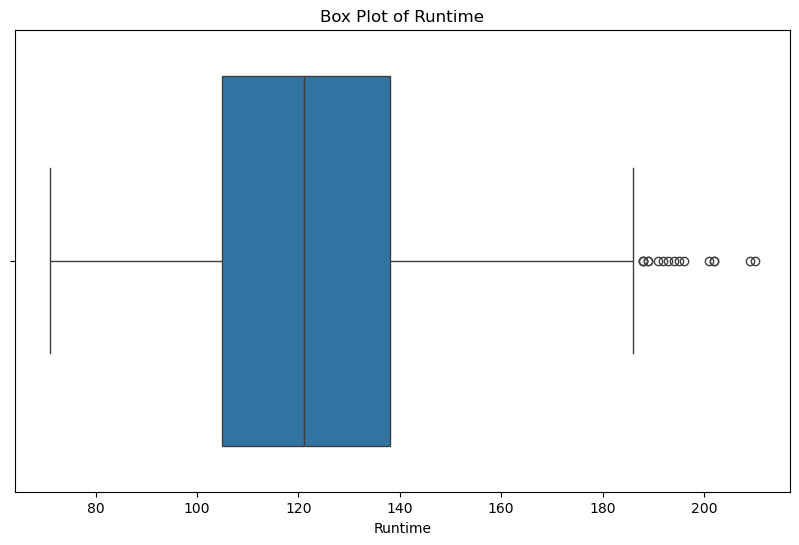

In [143]:
for column in numeric_columns:
    plt.figure(figsize=(10,6))
    sns.boxplot(x=data[column])
    plt.title(f"Box Plot of {column}")
    plt.show()

Upon further inspection, many movies have more than one genre in the `Genre` column. Doing an initial `data["Genre"].value_counts()`, it becomes evident that working with this format will be difficult. In order to understand the distribution of genre's of the dataset, it must be manipulated and broken down. 

In [144]:
# first, a copy of the dataset is made to modify its contents
# second, split the 'Genre' column by its delimiter (comma and space)
# third, explode list into separate rows (ie. if a movie is 'Romance, Comedy' then it will be broken into two rows, 
# one with 'Romance' the other with 'Comedy')
# NOTE: this is an inaccurate representation of the number of rows in the original data set
movie_genres = data.copy()
movie_genres["Genre"] = movie_genres["Genre"].str.split(', ')
movie_genres = movie_genres.explode("Genre")

After breaking down the `Genre` column and running `movie_genres["Genre"].value_counts()` it is more visually clear just how many movies are part of which genres. 

**NOTE: since each row was subdivided into however many genres the movie was categorized into, the total number of value counts is inaccurate.** (eg. if a movie is 'Romance, Comedy' then it will be broken into two rows, one with 'Romance' the other with 'Comedy' thus being counted twice.)

### **Part 2: Descriptive Statistics and Initial Insights**

#### **Basic Descriptive Statistics**
- what are the average, median, and standard deviation of the movie ratings?
- what is the distribution of movies by genre? which genre is the most common?

In [145]:
data["IMDB_Rating"].mean()

7.9288951841359765

The average IMDB rating for the remaining movies (706, down from 1000) is 7.93 out of 10.

In [146]:
data["IMDB_Rating"].median()

7.9

The median IMDB rating for the movies is 7.9. The average and median are close in range which means the dataset has a symmetrical distribution.

In [147]:
data["IMDB_Rating"].std()

0.28456894923794895

The standard deviation for the IMDB rating is 0.285 which is a measure of how distributed the data is in relation to mean. This closely follows the observation that the data has a symmetrical distribution.

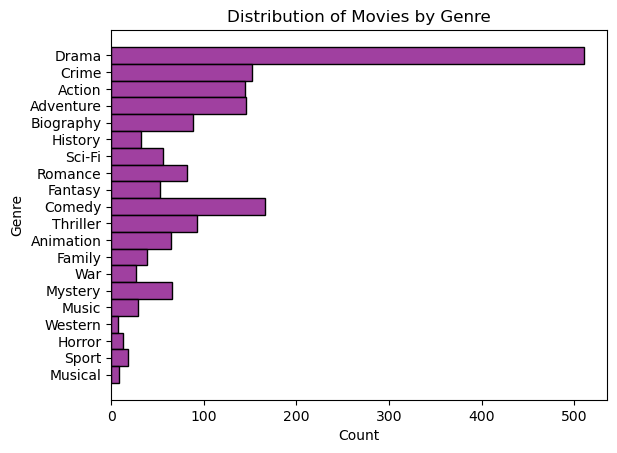

In [148]:
# x="Genre" creates a vertical graph, y="Genre" creates a horizontal graph
sns.histplot(data = movie_genres, y="Genre", color="purple")
plt.title("Distribution of Movies by Genre")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()

The most common genre in the data set is Drama with a count of over 500. The second most common genre is Comedy.

#### **Release Year Analysis**
- what are the distribution of movies by release year?
- are there any trends in movie production over the decades?

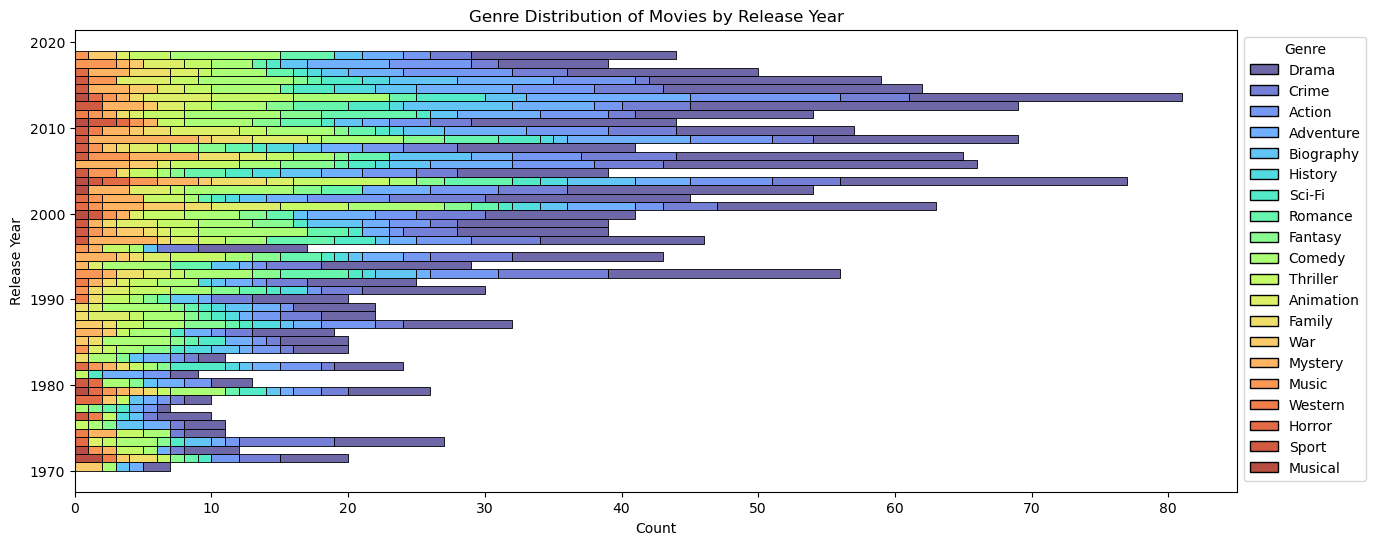

In [149]:
plt.figure(figsize=(15,6))
release_year_genre = sns.histplot(data=movie_genres, 
             y="Release_Year",
             bins=50, 
             hue="Genre",
             multiple="stack",
             palette=sns.mpl_palette("turbo", 20))

# moves the legend outside the graph
sns.move_legend(release_year_genre, "upper left", bbox_to_anchor=(1,1))
plt.title("Genre Distribution of Movies by Release Year")
plt.xlabel("Count")
plt.ylabel("Release Year")
plt.show()

The graph above shows the distribution of movies by release year. A common trend is that movies that fall under the "Drama" genre are produced the most often. This is evident as far back as 1972, more than 50 years ago. A possible reason for this could be that almost any movie can be categorized as "Drama" just for having good "dramatic acting", a staple for any film.  

### **Part 3: Deeper Analysis and Visualization**

#### **Rating Analysis**
- how do movie ratings vary by genre?
- are there specific years or decades where higher-rated movies are more common?

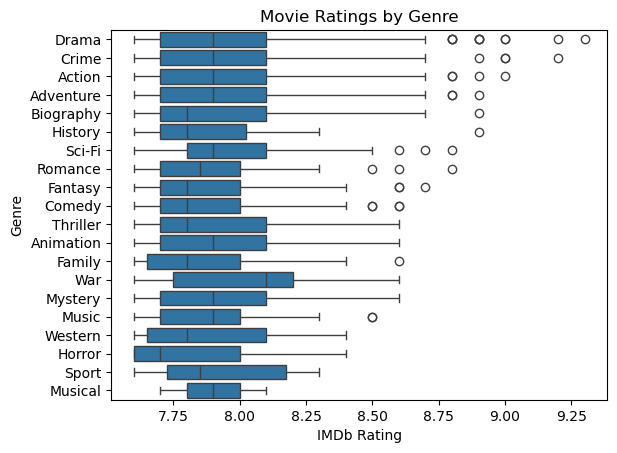

In [150]:
movie_ratings = movie_genres[["Release_Year", "Genre", "IMDB_Rating"]]
sns.boxplot(movie_ratings, x="IMDB_Rating", y="Genre")
plt.title("Movie Ratings by Genre")
plt.xlabel("IMDb Rating")
plt.ylabel("Genre")
plt.show()

Movies in the "War" genre have the highest median rating and movies in the "Horror" genre have the lowest median rating. With that said, the highest rating among all the movies in the dataset is in the "Drama" genre with "Crime" in second.

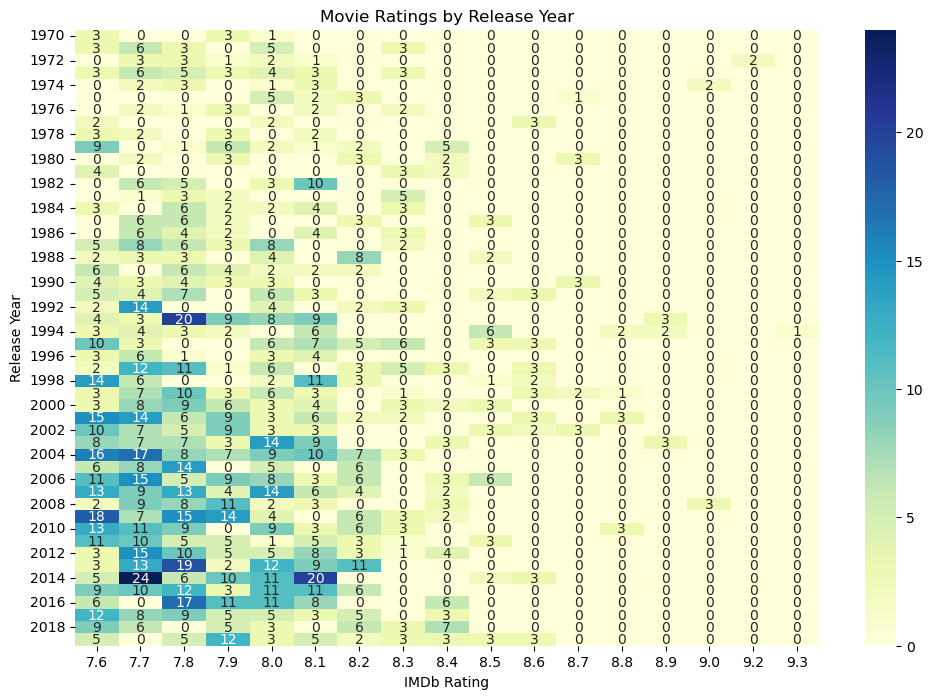

In [151]:
rating_distribution = movie_ratings.pivot_table(index='Release_Year', columns='IMDB_Rating', aggfunc='size', fill_value=0)

# plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(rating_distribution, cmap="YlGnBu", annot=True)
plt.title("Movie Ratings by Release Year")
plt.xlabel("IMDb Rating")
plt.ylabel("Release Year")
plt.show()

While there is no specific year where higher-rated movies are more common, it is a general trend that as we near present-day the number of movies released per year increases. This allows for more movies to reach a greater audience and have a higher average rating. 

#### **Genre and Revenue Analysis**
- which genres tend to generate the highest average revenue?
- which genres have the highest total revenue?

In [152]:
revenue_distribution = movie_genres[["Genre", "Gross"]]

# take the average gross revenue by Genre
revenue_distribution_avg = revenue_distribution.groupby(["Genre"]).mean().round()

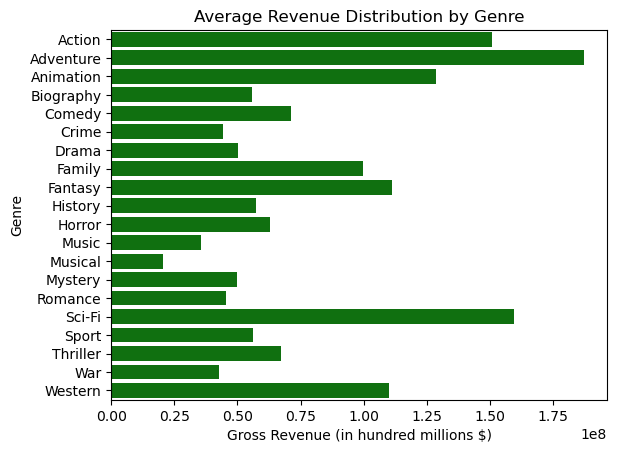

In [153]:
sns.barplot(revenue_distribution_avg, x="Gross", y="Genre", color="green")
plt.title("Average Revenue Distribution by Genre")
plt.xlabel("Gross Revenue (in hundred millions $)")
plt.ylabel("Genre")
plt.show()

The top 3 genres with the highest average revenue are [in order]: Adventure, Sci-Fi and Action. This can be confirmed by doing `revenue_distribution_avg.sort_values(by="Gross", ascending=False)` and those are the first three that appear in that order.

**NOTE: the average revenue is not entirely accurate as movies that were categorized with multiple genres would be contributing their gross revenue more than once.**

In [154]:
# find the sum of the gross revenue for each Genre
revenue_distribution_total = revenue_distribution.groupby(["Genre"]).sum()

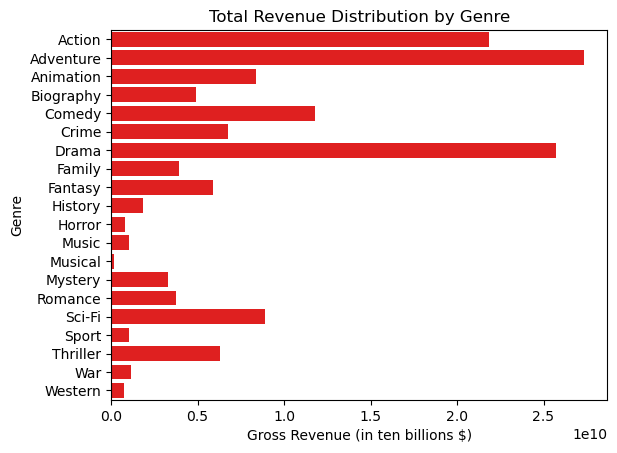

In [155]:
sns.barplot(revenue_distribution_total, x="Gross", y="Genre", color="red")
plt.title("Total Revenue Distribution by Genre")
plt.xlabel("Gross Revenue (in ten billions $)")
plt.ylabel("Genre")
plt.show()

Looking at total revenue instead of average revenue, we find that the top 3 genres are (in order): Adventure, Drama, Action. This can be confirmed by doing `revenue_distribution_total.sort_values(by="Gross", ascending=False)`.

**NOTE: the total revenue is not entirely accurate as movies that were categorized with multiple genres would be contributing their gross revenue more than once.**

### **Part 4: Advanced Insights**

#### **Director and Actor Analysis**
- who are the top directors based on the number of movies in the top 1000?
- are there any directors whose movies consistently have higher ratings?
- which actors appear most frequently in the top 1000 movies? do these actors have a higher average movie rating?

In [156]:
# find the number of times each director appears in the data set
top_directors = data["Director"].value_counts()
top_directors.head(10)

Director
Steven Spielberg     13
Martin Scorsese      10
Woody Allen           8
Christopher Nolan     8
Quentin Tarantino     8
David Fincher         8
Clint Eastwood        8
Rob Reiner            7
Hayao Miyazaki        7
Wes Anderson          6
Name: count, dtype: int64

Based on the number of movies in the top 1000, Steven Spielberg (13), Martin Scorsese (10) are the two best directors. Woody Allen, Christopher Nolan, Quentin Tarantino, David Fincher, Clint Eastwood are all tied for third place with 8 movies each in the top 1000.

You can manually check that the values below are correct by running: `data[data["Director"] == "[insert director name]"]` and calculating the average from the `IMDB_Rating` column. That value should match with the output from `consistent_directors` in the cell below.

In [157]:
consistent_directors = data.groupby(["Director"])

# only consider directors that have more than 2 movies on the list to ensure consistency and not just a one-time success
consistent_directors = consistent_directors.filter(lambda x: x["Director"].count() > 2)

# find the average IMDb rating for the "consistent" directors and sort in descending order
consistent_directors = consistent_directors.groupby(["Director"])["IMDB_Rating"].mean().sort_values(ascending=False)
consistent_directors

Director
Christopher Nolan       8.462500
Peter Jackson           8.400000
Francis Ford Coppola    8.400000
Stanley Kubrick         8.333333
Rajkumar Hirani         8.200000
                          ...   
Jim Jarmusch            7.733333
Andrey Zvyagintsev      7.733333
John Hughes             7.733333
Spike Lee               7.725000
Matthew Vaughn          7.650000
Name: IMDB_Rating, Length: 69, dtype: float64

In [161]:
top_actors = data.reset_index()

# take only the top movie stars and combine them into one [separated by commas]
# drop the columns that are not needed anymore
top_actors = top_actors[["Star1", "Star2", "Star3", "Star4"]]
top_actors["Cast"] = top_actors["Star1"] + ", " + top_actors["Star2"] + ", " + top_actors["Star3"] + ", " + top_actors["Star4"]
top_actors = top_actors.drop(columns=["Star1", "Star2", "Star3", "Star4"])

# now separate each actor into their own row
top_actors["Cast"] = top_actors["Cast"].str.split(', ')
top_actors = top_actors["Cast"].explode()

top_actors.value_counts().head(5)

Cast
Robert De Niro       16
Tom Hanks            13
Al Pacino            13
Brad Pitt            12
Leonardo DiCaprio    11
Name: count, dtype: int64

Robert De Niro (16), Tom Hanks (13), Al Pacino (13), Brad Pitt (12), Leonardo DiCaprio (11) are the top 5 actors that appear the most frequently in the top 1000 movies. 

In [ ]:
# take all movies that contain the actor name
# calculate avg imdb rating for their movies
# rank actor by avg imdb rating and see if its the same order